## Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
pathToImage = '/Users/nick/Downloads/neurofinder.02.00/images_summary/mean.tif'
pathToSources = '/Users/nick/Downloads/neurofinder.02.00/regions/regions3.json'
pathToSourcesGT = '/Users/nick/Downloads/neurofinder.02.00/regions/regionsRand.json'

In [4]:
import extraction as ex

In [5]:
model = ex.load(pathToSources)

In [6]:
from skimage.io import imsave, imread

In [7]:
im = imread(pathToImage)

In [8]:
from showit import image

## View region overlay

Compute overlay

In [54]:
from numpy import tile, maximum

In [218]:
base = tile((im.astype(float)/600).clip(0,1),(3,1,1)).transpose(1,2,0)
masks = model.regions.mask((512,512), background='black', fill=[0.8, 0, 0], stroke='white')
blend = maximum(base, masks)

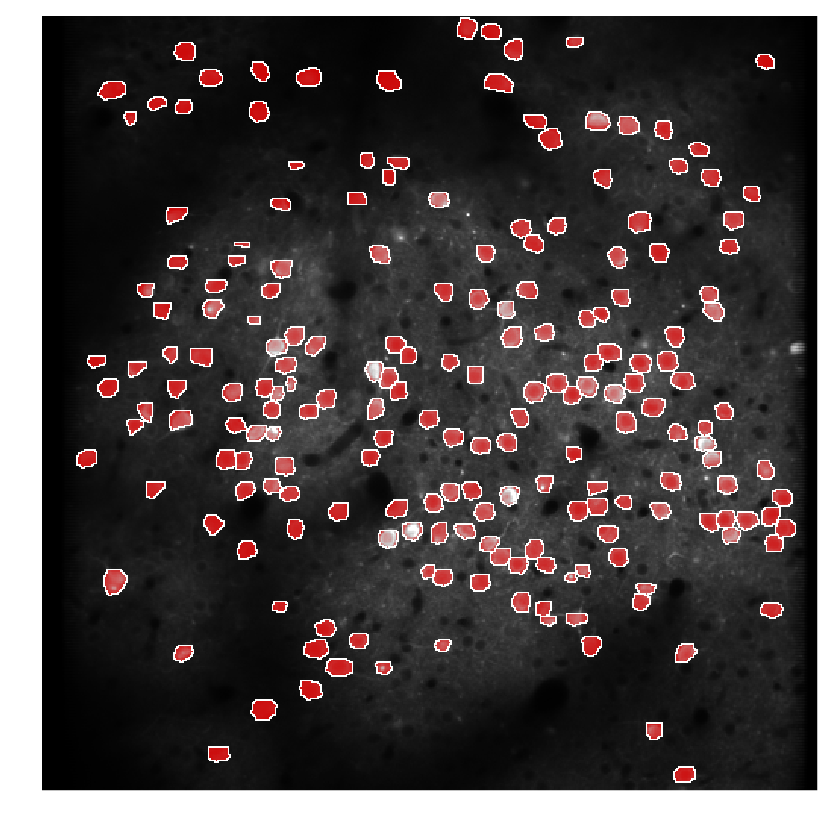

In [219]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);
#for s in range(randR.regions.count):
#    plt.annotate(s=str(s), xy=[model.regions.center[s][1],model.regions.center[s][0]], color='w', size = 10);

In [84]:
imsave(pathToImage[:-4] + '-sources.tif', (255*blend).astype('uint8'), plugin='tifffile', photometric='rgb')

## Compare two regions

Point to two different regions files - plot one in red, one in blue, hits in green, within distance threshold (default is inf)

Save results of region comparison (including neurofinder like summaries)

In [117]:
import neurofinder as nf

In [223]:
threshold = 5

In [124]:
matches = nf.match(model.regions, modelRand.regions, threshold)

In [220]:
recall, precision = nf.centers(model.regions, modelRand.regions, threshold)

In [221]:
inclusion, exclusion = nf.shapes(model.regions, modelRand.regions, threshold)

In [224]:
d = {'recall':recall, 'precision':precision, 'inclusion':inclusion, 'exclusion':exclusion, 'threshold':threshold}

In [227]:
import json
from os.path import join

In [228]:
output = '/Users/nick/Downloads/neurofinder.02.00/regions'
with open(join(output, 'results.json'), 'w') as f:
    f.write(json.dumps(d, indent=2))

In [155]:
from regional import many

In [170]:
from numpy import where, isnan, nan, full

In [181]:
matchesRR = full(modelRand.regions.count,nan)
for ii in where(~isnan(matches))[0]:
    matchesRR[matches[ii]] = ii

In [187]:
matchedA = ex.model.ExtractionModel([model.regions[i] for i in where(~isnan(matches))[0]])
matchedB = ex.model.ExtractionModel([model.regions[i] for i in where(isnan(matches))[0]])
matchedC = ex.model.ExtractionModel([modelRand.regions[i] for i in where(~isnan(matchesRR))[0]])
matchedD = ex.model.ExtractionModel([modelRand.regions[i] for i in where(isnan(matchesRR))[0]])

In [216]:
base = tile((im.astype(float)/600).clip(0,1),(3,1,1)).transpose(1,2,0)
masksA = matchedA.regions.mask((512,512), background='black', fill='green', stroke='black')
masksB = matchedB.regions.mask((512,512), background='black', fill='red', stroke='black')
masksC = matchedC.regions.mask((512,512), background='black', fill='green', stroke='white')
masksD = matchedD.regions.mask((512,512), background='black', fill=[.7, 0, 0], stroke='white')
X = maximum(maximum(maximum(masksA, masksB), masksC), masksD)
blend = maximum(base, X)

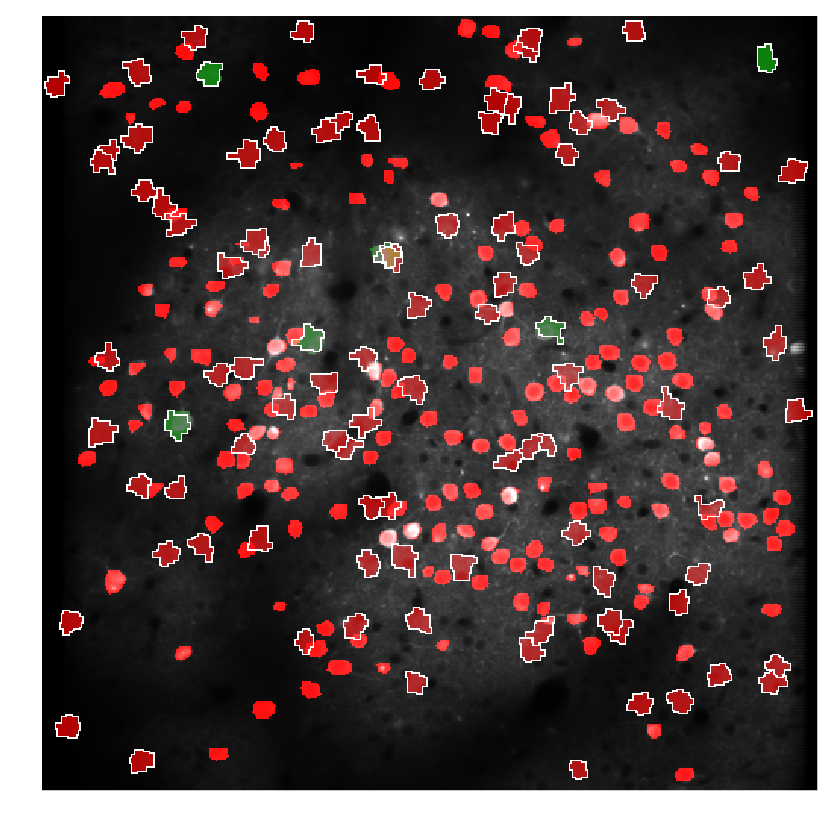

In [217]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);
#for s in range(randR.regions.count):
#    plt.annotate(s=str(s), xy=[model.regions.center[s][1],model.regions.center[s][0]], color='w', size = 10);

## Make random regions

In [86]:
from regional import one, many
from showit import image
from numpy import zeros, random, asarray, round, where, ones
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_fill_holes, binary_dilation

In [108]:
dims = [512,512]
margin = 20
n = 100

In [109]:
def topoly(c):
    tmp = zeros(dims)
    coords = asarray([c[0] + random.randn(32) * 3, c[1] + random.randn(32) * 3]).astype('int')
    tmp[coords.tolist()] = 1
    tmp = binary_dilation(tmp, ones((3, 3)))
    tmp = binary_closing(tmp, ones((7, 7)))
    return asarray(where(tmp)).T

xcenters = (dims[0] - margin) * random.random_sample(n) + margin/2
ycenters = (dims[1] - margin) * random.random_sample(n) + margin/2
centers = zip(xcenters, ycenters)

In [110]:
regions = many([one(topoly(c)) for c in centers])

In [111]:
modelRand = ex.model.ExtractionModel(regions)